### Basic Nerual Network
Followed tutioral from:
https://www.youtube.com/watch?v=VMj-3S1tku0&t=2143s&ab_channel=AndrejKarpathy

In [84]:
#Libraries to be install
import numpy as np
import math
import graphviz as gv
from graphviz import Digraph
import random

# Nerual Network Math #
Derivative: $(f(x+h) - f(x)) \over h$ \
$ tanh (x) =  \frac{e^x-e^{-x}}{e^x+e^{-x}} $ 

In [85]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  # Returns string representation of the object
  def __repr__(self):
    return f"Value(data={self.data})"
  
  # Returns addition of other Value object
  def __add__(self, other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  # Returns multiplcation of other Value object 
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  # Implmentation of hyperbolic tangent
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  # Back propogation for nodes
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [86]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [87]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L.grad = 1

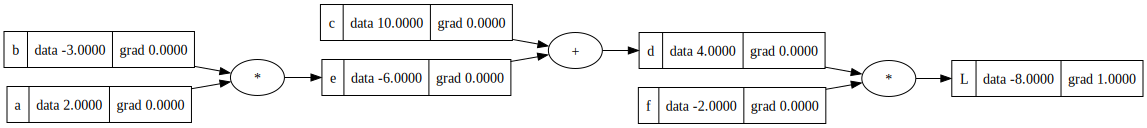

In [88]:
draw_dot(L)

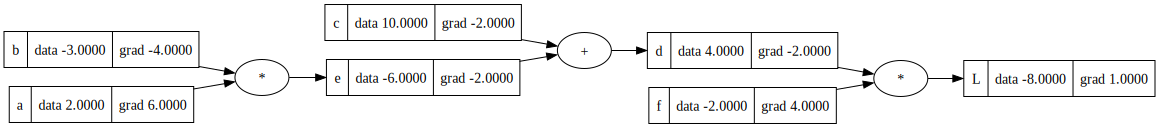

In [89]:
L.backward()
draw_dot(L)

In [90]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

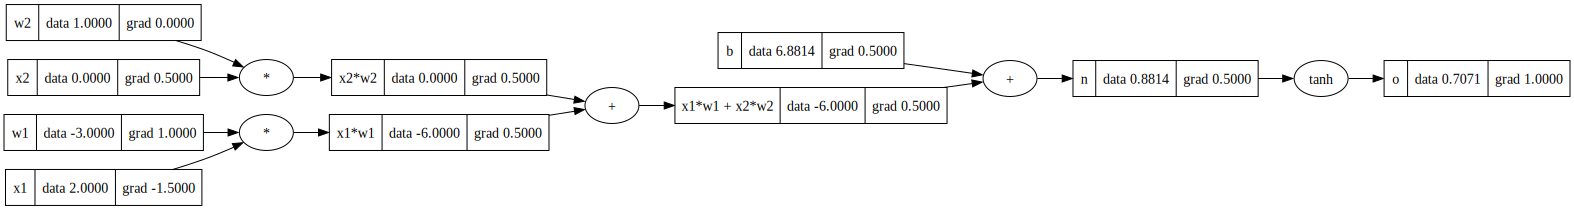

In [91]:
o.backward()
draw_dot(o)

In [92]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [93]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [94]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.2897222991841944)

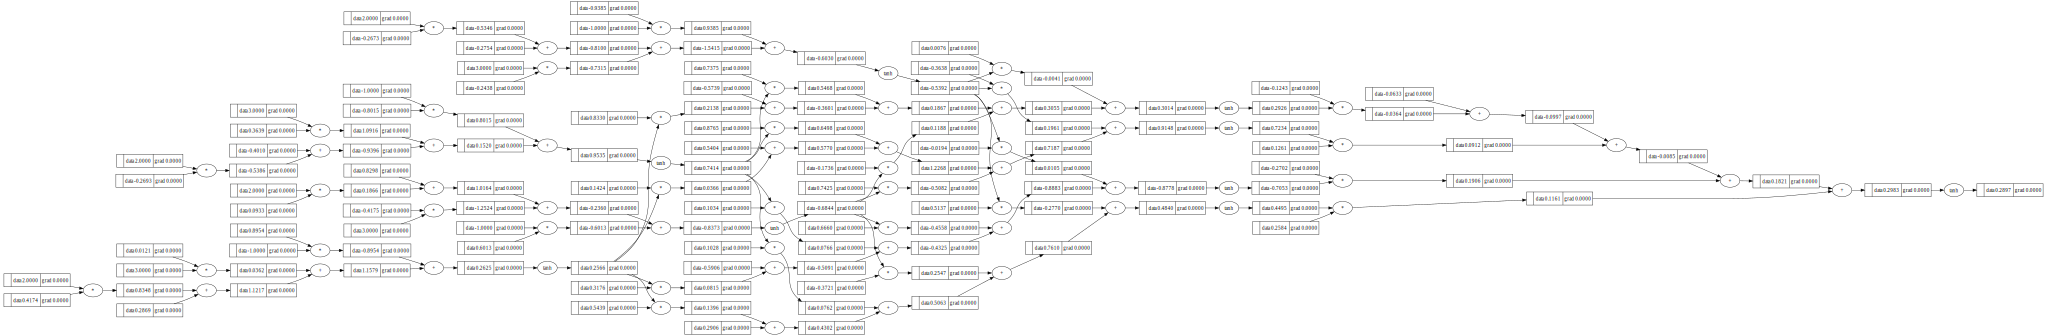

In [95]:
draw_dot(n(x))

In [96]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

Loss Function = Performance of the Net

# Types of Loss Functions #
 * Regression:
   - Mean Squared Error (MSE): $MSE =\frac{1}{n}\sum_{i=1}^{n}\left[\left(Y_i-{\hat{Y}}_i\right)^2\right] $ \
      ${n}$	=	number of data points \
      $Y_{i}$	=	observed values \
      $\hat{Y}_{i}$	=	predicted values

    - Mean Absolute Error (MAE): $MAE =\frac{1}{n}\sum_{j=1}^{n}\left|y_j-{\hat{y}}_j\right|$ \
      ${n}$	=	number of data points \
      $y_{j}$	=	observed values \
      $\hat{y}_{j}$	=	predicted values

    - Root Mean Squared Error (RMSE): $RMSE = \sqrt{\frac{\sum_{i=1}^{N}\left[\left(x_i-{\hat{x}}_i\right)^2\right]\ \ }{N}}$ \
      ${N}$	=	number of data points \
      $x_{i}$	=	observed values \
      $\hat{x}_{j}$	=	predicted values

    - Mean Bias Error (MBE): $MBE = \frac{1}{n}\sum_{i=1}^{n}{\left(y-{\hat{y}}_i\right)^2\ }$ \
      ${n}$	=	number of data points \
      $y_{j}$	=	observed values \
      $\hat{y}_{j}$	=	predicted values
    - Huber Loss (HL): $HL = L_i=\left\{\begin{matrix}{\frac{1}{2}\left(y-f(x)\right)}^2&for\ \left|y-f(x)\right|\le\delta\\\delta\left(\left|y-f\left(x\right)\right|-\frac{1}{2}\delta\right)&for\ \left|y-f(x)\right|>\delta\\\end{matrix}\right. $ \
      ${y}$	=	predicted values \
      $f(x)$	=	$mx + b$ where $m$ is the slope of the line and $b$ is the y-intercept \
      $\delta$	=	Transition point from a quadratic function to a linear function

 * Binary Classification:
    - Binary Cross Entropy (BCE) $H_p\left(q\right)=-\frac{1}{N}\sum_{i=1}^{N}{y_i\cdot\log(p\left(y_i\right)+(1-y_i)\cdot \log(1-p\left(y_i\right))}$ \
    $y_{i}$ = label \
    $p(y_{i})$ predicted probability \
    $N$ = number of data points

    - Hing Loss and Squared Hing Loss (HL and SHL): $HL = \ell\left(y\right)=\max{\left(0,1-t\cdot y\right)}$ \
    $SHL = $
    - Likelihood Loss (LHL) $\sum_{i=1}^{N}{x_i\cdot\log(p\left(x_i\right)+(1-y_i)\cdot \log(1-p\left(x_i\right))}$
 * Multinomial Classification:
    - Categorical Cross Entropy (CCE)
    - Kullback-Leibler Divergence (KLD):
      - (discrete probability distributions): $D_{KL}(P|\left|Q\right)= \sum_{x\in X}{P\left(x\right)\log{\left(\frac{P\left(x\right)}{Q\left(x\right)}\right)}}$ \
      - (continuous random variable): $D_{KL}(P || Q) = \int_{-\infty}^{\infty} p(x) \log \frac{p(x)}{q(x)} dx$ \
   $p(x)$ = Probability density function of distribution P \
   $q(x)$ = Probability density function of distribution Q \
   $P$ = "true" or "actual" distribution \
   $Q$ = Q is a model or approximation of P \
   $X$ = Relative entropy \

In [101]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 0.003932135593375852
1 0.0038799012428148783
2 0.003828994454008754
3 0.0037793658477835337
4 0.003730968448329876
5 0.0036837575393246893
6 0.0036376905302381475
7 0.003592726831996298
8 0.003548827741245786
9 0.0035059563325357257
10 0.00346407735779327
11 0.003423157152524862
12 0.0033831635482246274
13 0.0033440657905176507
14 0.0033058344626048157
15 0.003268441413614232
16 0.003231859691496971
17 0.0031960634801346845
18 0.0031610280403547844
19 0.003126729654573445


In [98]:
ypred

[Value(data=0.9449567534692094),
 Value(data=-0.9433722944204461),
 Value(data=-0.9239987165943847),
 Value(data=0.9146540880137273)]